In [1]:
from gloria.datasets.visualization_utils import *
import pandas as pd
import os
import skimage
from torch import nn


def get_attn_overlay(attn, image_shape):
    new_attn = torch.tensor(attn)
#     new_attn = nn.Upsample(size=image_shape)(new_attn.reshape(1, 1, *new_attn.shape))[0, 0]
    new_attn = new_attn.unsqueeze(-1).expand(*new_attn.shape, 3)
    new_attn = skimage.transform.pyramid_expand(
        new_attn, sigma=20, upscale=image_shape[0] // new_attn.shape[0], multichannel=True)
    new_attn = torch.tensor(new_attn[:, :, 0])
    new_attn = nn.Upsample(size=image_shape)(new_attn.reshape(1, 1, *new_attn.shape))[0, 0]
    return new_attn

In [2]:
paths = {
#     'original_small': '/scratch/mcinerney.de/gloria_outputs/output/gloria_pretrain_1.0/2021_11_30_20_55_42/val_outputs_0',
    'original': '/scratch/mcinerney.de/gloria_outputs/output/gloria_pretrain_1.0/2021_12_01_03_35_11/val_outputs_0/',
#     'retrained_sparse': '/scratch/mcinerney.de/gloria_outputs/output/gloria_pretrain_1.0/2021_11_30_23_41_57/val_outputs_0/'
#     'retrained': '/scratch/mcinerney.de/gloria_outputs/output/gloria_pretrain_1.0/2021_12_01_03_34_04/val_outputs_0/'
}


In [18]:
# selector = OrSelector(
#              RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
#              RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
#          )
selector = None
for k, path in paths.items():
    df = pd.read_csv(os.path.join(path, 'sentences.csv'))
    print(k, len(df))
#     rows = df[df.apply(selector, axis=1)].iloc[:100]
    rows = df.iloc[:100]
    print('len', len(rows), 'auroc', rows.auroc.mean(), 'avg_precision', rows.avg_precision.mean())
#     info = path_and_rows_to_info(path, rows=rows)
#     plot_info(get_attn_overlay, info, path=path)
plt.close()

original 4608
len 100 auroc 0.6337288675867782 avg_precision 0.43572656779873126


In [19]:
import os
from jupyter_innotater import *
import pandas as pd


def visualize(model_paths, selector=None):
    min_list_of_files = None
    for model_path in model_paths.values():
        fs = set(os.listdir(os.path.join(model_path, 'sentence_figures')))
        df = pd.read_csv(os.path.join(model_path, 'sentences.csv'))
        if selector is not None:
            df = df[df.apply(selector, axis=1)]
        fs = fs.intersection(set([dicom_sent_id + '.jpg' for dicom_sent_id in set(df.dicom_sent_id)]))
        if min_list_of_files is None:
            min_list_of_files = fs
        else:
            min_list_of_files = min_list_of_files.intersection(fs)
    min_list_of_files = sorted(list(min_list_of_files))
    innotations = [
        innotation
        for model_name, model_path in model_paths.items()
        for innotation in [
            TextInnotation([model_name] * len(min_list_of_files)),
            TextInnotation(min_list_of_files),
            ImageInnotation(min_list_of_files, path=os.path.join(model_path, 'sentence_figures'))
        ]
    ]
    return Innotater(
        innotations,
        []
    )

In [20]:
visualize(paths, selector=selector)

Innotater(children=(HBox(children=(VBox(children=(Textarea(value='original', disabled=True), Textarea(value='d…

In [6]:
from omegaconf import OmegaConf
import gloria
from gloria.datasets.mimic_for_gloria import GloriaCollateFn
from gloria.lightning.callbacks import EvaluateLocalization
from gloria.lightning.pretrain_model import PretrainModel

def get_instance(dicom_id, sent_id, dataset, replace_sent_with=None):
    rows = dataset.df[dataset.df.dicom_id == dicom_id]
    instance = dataset.get_item_from_rows(rows)
    instance = dataset.add_objects(instance, sent_id=sent_id)
    if replace_sent_with is not None:
        patient_id = next(iter(instance.keys()))
        study_id = next(iter(instance[patient_id].keys()))
        instance[patient_id][study_id]['sentence'] = replace_sent_with
        instance[patient_id][study_id]['objects'][dicom_id]['sent_to_bboxes'][sent_id]['sentence'] = replace_sent_with
    return instance

def display(instance):
    patient_id = next(iter(instance.keys()))
    study_id = next(iter(instance[patient_id].keys()))
    print(instance[patient_id][study_id]['sentence'])
    img = instance[patient_id][study_id]['images'][dicom_id]
    plt.imshow(to_rgb(img))
    

In [7]:
cfg = OmegaConf.load('configs/chexpert_pretrain_imagenome_val_config.yaml')
dm = gloria.builder.build_data_module(cfg)
collate_fn = GloriaCollateFn(cfg, "test")
el = EvaluateLocalization(collate_fn)
module = PretrainModel.load_from_checkpoint('./pretrained/chexpert_resnet50.ckpt')
module.eval()
valid = dm.dm.get_dataset('valid')

downloaded


There is mild linear atelectatic changes at the right base.


/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thresholds = tensor(reversed(thresholds[sl]))
/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have 

{'info': {'dicom_sent_id': ['dicom_2533ab2a-565051cb-35201672-0267a457-d931d20f_sent_55609974|8'],
  'patient_id': [14090353],
  'study_id': [55609974],
  'dicom_id': ['2533ab2a-565051cb-35201672-0267a457-d931d20f'],
  'sent_id': ['55609974|8'],
  'sentence': ['There is mild linear atelectatic changes at the right base.'],
  'bbox_names': [['right lung', 'right lung', 'right lung', 'right lung']],
  'sent_labels': [['atelectasis',
    'linear/patchy atelectasis',
    'lung opacity',
    'abnormal']],
  'sent_contexts': [['yes', 'yes', 'yes', 'yes']],
  'original_image': [array([[ 0,  0,  0, ...,  0,  0,  0],
          [ 0, 44, 44, ..., 55, 57, 56],
          [ 0, 42, 44, ..., 57, 58, 58],
          ...,
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)],
  'original_bboxes': [[[238, 0, 1099, 1099],
    [238, 0, 1099, 1099],
    [238, 0, 1099, 1099],
    [238, 0, 1099, 1099]]],
  'image': [array([[-0.

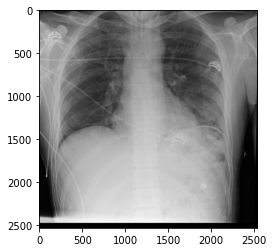

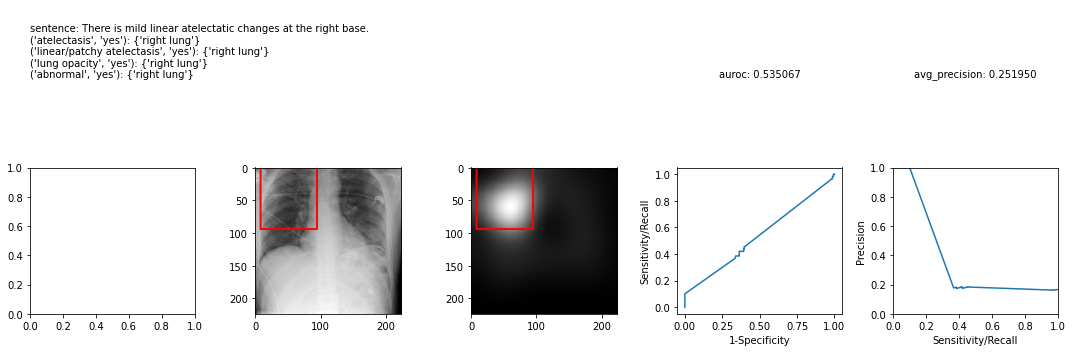

In [23]:
dicom_id = '2533ab2a-565051cb-35201672-0267a457-d931d20f'
sent_id = '55609974|8'
instance = get_instance(dicom_id, sent_id, valid)
display(instance)
el.evaluate_and_save(
    path='experiments2', instances=[instance], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

Donkeys like to fly kites.


/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thresholds = tensor(reversed(thresholds[sl]))
/home/mcinerney.de/.conda/envs/gloria_new/lib/python3.8/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have 

{'info': {'dicom_sent_id': ['dicom_2533ab2a-565051cb-35201672-0267a457-d931d20f_sent_55609974|8'],
  'patient_id': [14090353],
  'study_id': [55609974],
  'dicom_id': ['2533ab2a-565051cb-35201672-0267a457-d931d20f'],
  'sent_id': ['55609974|8'],
  'sentence': ['Donkeys like to fly kites.'],
  'bbox_names': [['right lung', 'right lung', 'right lung', 'right lung']],
  'sent_labels': [['atelectasis',
    'linear/patchy atelectasis',
    'lung opacity',
    'abnormal']],
  'sent_contexts': [['yes', 'yes', 'yes', 'yes']],
  'original_image': [array([[ 0,  0,  0, ...,  0,  0,  0],
          [ 0, 44, 44, ..., 55, 57, 56],
          [ 0, 42, 44, ..., 57, 58, 58],
          ...,
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0],
          [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)],
  'original_bboxes': [[[238, 0, 1099, 1099],
    [238, 0, 1099, 1099],
    [238, 0, 1099, 1099],
    [238, 0, 1099, 1099]]],
  'image': [array([[-0.17647058, -0.19999999, -0.1999999

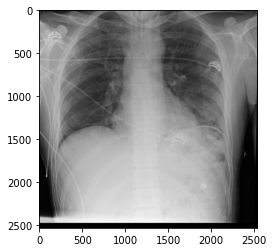

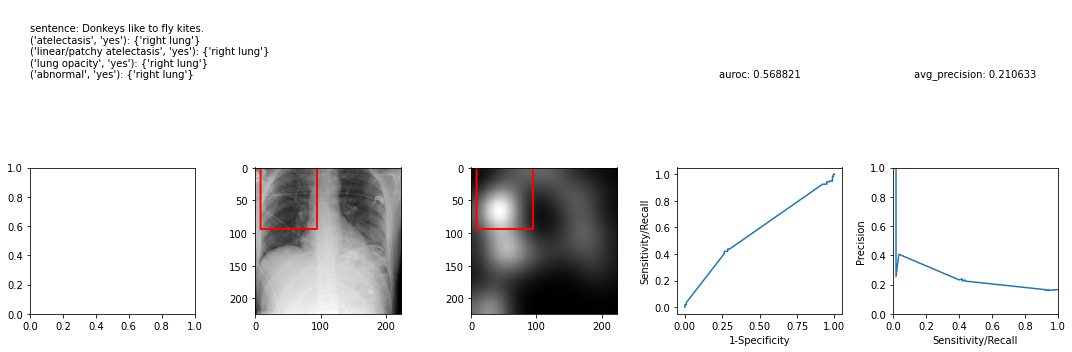

In [24]:
neg_instance = get_instance(dicom_id, sent_id, valid, replace_sent_with='Donkeys like to fly kites.')
display(neg_instance)
el.evaluate_and_save(
    path='experiments4', instances=[neg_instance], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

In [ ]:
visualize({'regular': 'experiments', 'reversed': 'experiments_neg'})